# <机器学习>课程 Lecture2 实验

## 高斯判别性分析

给定一组数据,其输入维度为2,输出维度为1,完成二分类任务.

请使用高斯判别性分析来进行分类并绘制类别分界面.

首先加载数据.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

data_filename = "cls_data_0303_1007_2.npy"
cls_data = np.load(data_filename)
x_data, y_data = cls_data[:, :-1], cls_data[:, -1]

x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data,
    train_size=0.8, shuffle=True,
    stratify=y_data
)

# x_data in [b, c_in]
c_in = x_data.shape[1]
# y_data in [b, c_out]
c_out = 1


定义高斯判别性分析.

在fit函数中分别统计不同类别的数据的均值和协方差.

在predict中根据均值和协方差矩阵计算概率,并选择概率最大的类别作为输出.

In [3]:
import numpy as np
from scipy.stats import multivariate_normal

class GaussianDiscriminantAnalysis():
    """
    高斯判别性分析
    """
    def __init__(self,
        same_cov: bool=False
    ) -> None:
        """
        same_cov 是否具有相同的协方差
        """
        self.c_in = None
        self.classes = None
        self.means = None
        self.covs = None
        self.same_cov = same_cov

    def fit(self,
        x: np.ndarray, y:np.ndarray
    )->None:
        assert len(x.shape) == 2
        assert x.shape[0] == y.shape[0]

        self.c_in = x.shape[1]
        self.classes = np.unique(y)

        means = []
        covs = []
        # 对于每一个类别,分别计算数据的均值和方差
        # 使用高斯函数拟合数据分布
        for cc in self.classes:
            x_class = x[y==cc]
            mean = x_class.mean(axis=0)
            cov = np.cov(x_class, rowvar=False)
            means.append(mean)
            covs.append(cov)

        self.means = np.array(means)
        self.covs = np.array(covs)

        assert self.means.shape[0] == len(self.classes)
        assert self.means.shape[1] == self.c_in
        assert self.covs.shape[0] == len(self.classes)

        # 假定不同类别的数据有相同的协方差
        if self.same_cov:
            avg_cov = np.mean(self.covs, axis=0)
            self.covs = np.array([avg_cov for _ in range(len(self.classes))])

    def predict(self,
        x: np.ndarray
    )->np.ndarray:
        probs = np.zeros((x.shape[0], len(self.classes)))
        # 对于每一个类别计算预测概率
        for idx, cc in enumerate(self.classes):
            mean = self.means[idx]
            cov = self.covs[idx]
            prob = multivariate_normal.pdf(x, mean=mean, cov=cov)
            probs[:, idx] = prob
        assert probs.shape[0] == x.shape[0]
        assert probs.shape[1] == len(self.classes)

        return probs.argmax(axis=1)


In [4]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

#可视化函数
def plot_decision_regions(x, y, classifier, resolution=0.02):
    markers = ['s', 'o', '^', 'v']
    colors = ['r', 'g', 'b', 'cyan']
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    grid = np.array([xx1.ravel(), xx2.ravel()]).T

    # == 对于生成meshgrid的每一个点计算降维和分类结果 ==
    z = classifier.predict(grid)
    z = z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, z, alpha=0.4, cmap=cmap)

    for idx, cc in enumerate(np.unique(y)):
        plt.scatter(x=x[y[:, 0] == cc, 0],
                    y=x[y.ravel() == cc, 1],
                    alpha=0.6,
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx],
                    label=cc)


0.92


/var/folders/j9/slfj11xj3s9848644gvf6cvw0000gn/T/ipykernel_72778/3700982331.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=x[y[:, 0] == cc, 0],


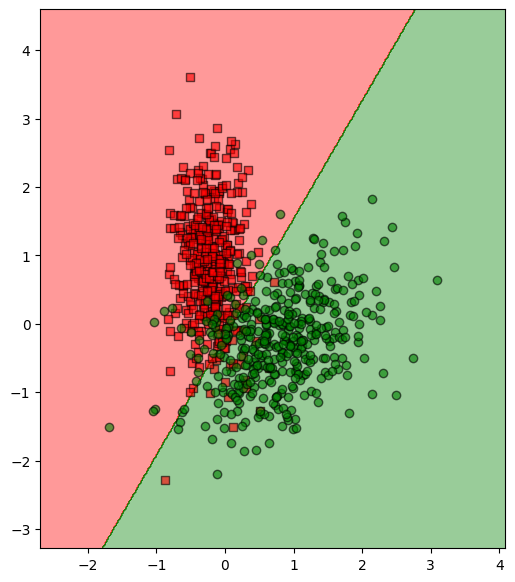

In [5]:
model = GaussianDiscriminantAnalysis(same_cov=True)
model.fit(x_train, y_train)

res = model.predict(x_test)
accuracy = np.sum(res == y_test) / x_test.shape[0]
print(accuracy)

plt.figure(figsize=(6, 7), dpi=100)  
plot_decision_regions(x_train, y_train[:, np.newaxis], classifier=model)
plt.show()

0.935


/var/folders/j9/slfj11xj3s9848644gvf6cvw0000gn/T/ipykernel_72778/3700982331.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=x[y[:, 0] == cc, 0],


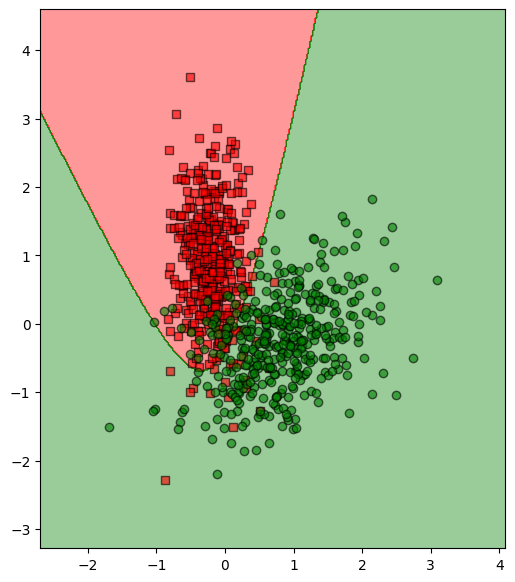

In [6]:
model = GaussianDiscriminantAnalysis(same_cov=False)
model.fit(x_train, y_train)

res = model.predict(x_test)
accuracy = np.sum(res == y_test) / x_test.shape[0]
print(accuracy)

plt.figure(figsize=(6, 7), dpi=100)  
plot_decision_regions(x_train, y_train[:, np.newaxis], classifier=model)
plt.show()